# Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression

**Tujuan**: Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression, lalu menerapkan threshold untuk klasifikasi status

**Lokasi**: Bangkalan, Madura

**Data Source**: Sentinel-5P (Copernicus Data Space)

**Metode**: 
1. KNN Regression untuk prediksi nilai kontinyu
2. Threshold Application untuk klasifikasi (Aman/Berbahaya)

**Periode**: Juni 2024 - Juni 2025

## Import Libraries

In [1]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Semua library berhasil diimport")

Semua library berhasil diimport


---

# DATA UNDERSTANDING

**Data Understanding** adalah tahap untuk memahami karakteristik dan kualitas data sebelum melakukan analisis.

## Yang Dilakukan dalam Tahap Ini:

1. **Mengumpulkan Data** dari Sentinel-5P (satelit pemantau polusi udara)
2. **Mengeksplorasi Struktur Data**: Melihat jumlah baris, kolom, tipe data
3. **Statistik Deskriptif**: Mean, std, min, max dari NO₂
4. **Visualisasi Time Series**: Melihat pola dan trend data NO₂
5. **Deteksi Missing Values**: Mengidentifikasi data yang hilang
6. **Analisis Distribusi**: Memahami sebaran nilai NO₂

**Output**: Pemahaman tentang data NO₂ Bangkalan periode Juni 2024 - Juni 2025

---



## LANGKAH 1: Pengumpulan Data (Data Collection)

**Kategori: DATA UNDERSTANDING**

**Sumber**: Sentinel-5P via OpenEO (Copernicus Data Space)

**Output**: CSV dengan data NO₂ harian untuk periode Juni 2020 - Juni 2021

**Tujuan**:
- Mengumpulkan data time series NO₂ dari satelit
- Memahami struktur dan format data
- Menyimpan data mentah untuk analisis lanjutan

In [2]:
print("="*70)
print("LANGKAH 1: PENGUMPULAN DATA ")
print("="*70)

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. Area of Interest (AOI) - Bangkalan, Madura
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.72456356837233, -7.026115991674629],
            [112.72456356837233, -7.064639201806031],
            [112.77959573996094, -7.064639201806031],
            [112.77959573996094, -7.026115991674629],
            [112.72456356837233, -7.026115991674629],
        ]
    ],
}

# 3. Load data Sentinel-5P
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.72456356837233,
        "south": -7.064639201806031,
        "east": 112.77959573996094,
        "north": -7.026115991674629,
    },
    temporal_extent=["2020-06-01", "2021-06-30"],
    bands=["NO2"],
)

# 4. Mask nilai negatif
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal (harian)
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (mean dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job
job = daily_mean_aoi.execute_batch(out_format="CSV")
print("\nMenunggu job OpenEO selesai...")

while True:
    status = job.describe()["status"]
    print(f"Status: {status}")
    if status == "finished":
        break
    elif status == "error":
        raise RuntimeError("Job gagal")
    time.sleep(15)

# 8. Unduh hasil
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV
csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

# 10. Data preprocessing
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df.to_csv("timeseries.csv", index=False)

print(f"\nData berhasil dikumpulkan")
print(f"  - Total records: {len(df)}")
print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
print(f"  - File: timeseries.csv")
print(f"\nData pertama (5 baris):")
print(df.head())

LANGKAH 1: PENGUMPULAN DATA 
Authenticated using refresh token.
Authenticated using refresh token.
0:00:00 Job 'j-2510220904584c35ae25d3d2ecd1e614': send 'start'
0:00:00 Job 'j-2510220904584c35ae25d3d2ecd1e614': send 'start'
0:00:13 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:13 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:19 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:19 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:27 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:27 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:35 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:35 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:45 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:45 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progress 0%)
0:00:58 Job 'j-2510220904584c35ae25d3d2ecd1e614': queued (progres

---

# DATA PREPARATION

**Data Preparation** adalah tahap mempersiapkan data mentah menjadi format yang siap untuk modeling.

## Yang Dilakukan dalam Tahap Ini:

### 1. Handling Missing Values (Langkah 2)
- Mengisi missing values dengan **interpolasi linear**
- Backup dengan backfill dan forwardfill
- Memastikan tidak ada data yang hilang

### 2. Transformasi Time Series ke Supervised Learning (Langkah 3)
- Membuat **lagged features**: NO2(t-3), NO2(t-2), NO2(t-1)
- Menetapkan **target**: NO2(t)
- Mengubah format data menjadi input-output untuk machine learning

### 3. Normalisasi Data (Langkah 4)
- Menggunakan **StandardScaler** (Z-score normalization)
- Menyamakan skala semua fitur (mean=0, std=1)
- Penting untuk KNN karena sensitif terhadap skala

### 4. Train-Test Split & Threshold (Langkah 5)
- Split data: 80% training, 20% testing (**shuffle=False** untuk time series)
- Menentukan **threshold** (75th percentile)
- Membuat binary labels (AMAN/BERBAHAYA) untuk evaluasi

**Output**: Data yang bersih, terstruktur, dan siap untuk training model

---



## LANGKAH 2: Preprocessing - Interpolasi Missing Values

**Kategori: DATA PREPARATION**

**Tujuan**: Menangani missing values dengan interpolasi linier

**Proses**:
1. Identifikasi missing values (Data Understanding)
2. Interpolasi linear untuk mengisi missing values
3. Backup dengan backfill dan forwardfill
4. Validasi: memastikan tidak ada missing values tersisa


LANGKAH 2: PREPROCESSING - INTERPOLASI MISSING VALUES

Missing values SEBELUM: 261 (66.08%)
Missing values SESUDAH: 0

Statistik NO2 setelah interpolasi:
count    3.950000e+02
mean     2.633213e-05
std      1.225453e-05
min      9.267380e-07
25%      1.763298e-05
50%      2.534530e-05
75%      3.466008e-05
max      7.045191e-05
Name: NO2, dtype: float64


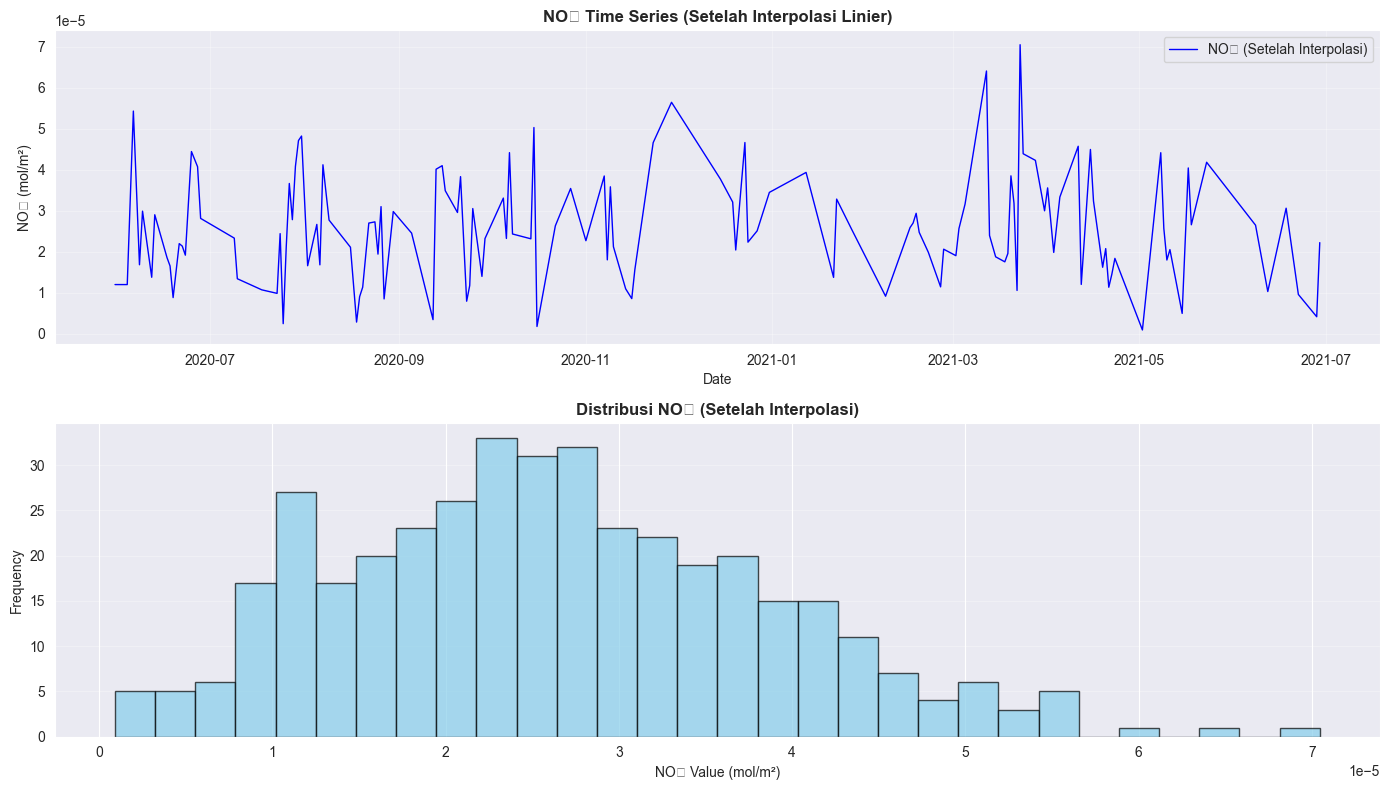


Preprocessing selesai


In [3]:
print("\n" + "="*70)
print("LANGKAH 2: PREPROCESSING - INTERPOLASI MISSING VALUES")
print("="*70)

# Baca data
df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Cek missing values SEBELUM
missing_before = df["NO2"].isna().sum()
print(f"\nMissing values SEBELUM: {missing_before} ({missing_before/len(df)*100:.2f}%)")

# Interpolasi linier
df["NO2"] = df["NO2"].interpolate(method="linear")
df["NO2"] = df["NO2"].fillna(method="bfill").fillna(method="ffill")

# Cek missing values SESUDAH
missing_after = df["NO2"].isna().sum()
print(f"Missing values SESUDAH: {missing_after}")

# Statistik
print(f"\nStatistik NO2 setelah interpolasi:")
print(df["NO2"].describe())

# Visualisasi
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df["date"], df["NO2"], color="blue", linewidth=1, label="NO₂ (Setelah Interpolasi)")
axes[0].set_title("NO₂ Time Series (Setelah Interpolasi Linier)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("NO₂ (mol/m²)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(df["NO2"], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
axes[1].set_title("Distribusi NO₂ (Setelah Interpolasi)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO₂ Value (mol/m²)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nPreprocessing selesai")

---

## LANGKAH 3: Transformasi ke Supervised Learning

**Kategori: DATA PREPARATION**

**Tujuan**: Konversi time series menjadi supervised dataset dengan lagged features

**Konsep**: Gunakan 3 hari terakhir (t-3, t-2, t-1) untuk memprediksi NO₂ hari ini (t)

**Proses**:
1. Membuat fungsi `series_to_supervised()`
2. Generate lagged features (NO2(t-3), NO2(t-2), NO2(t-1))
3. Set target variable (NO2(t))
4. Drop rows dengan NaN (hasil shifting)

In [4]:
print("\n" + "="*70)
print("LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING")
print("="*70)

def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    """
    Konversi time series menjadi supervised learning dataset.
    """
    df_data = pd.DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_data.shift(i))
        names += [f"NO2(t-{i})"]

    # Output sequence (t)
    for i in range(0, n_out):
        cols.append(df_data.shift(-i))
        if i == 0:
            names += ["NO2(t)"]
        else:
            names += [f"NO2(t+{i})"]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropna:
        agg.dropna(inplace=True)

    return agg

# Gunakan 3 lag
n_lags = 3
supervised_df = series_to_supervised(df[["NO2"]], n_in=n_lags, n_out=1)

print(f"\nTransformasi supervised learning dengan lag={n_lags}")
print(f"  - Total samples: {len(supervised_df)}")
print(f"  - Input fitur: {n_lags} (t-1 hingga t-{n_lags})")
print(f"  - Target: 1 (t)")
print(f"\nData pertama (5 baris):")
print(supervised_df.head())


LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING

Transformasi supervised learning dengan lag=3
  - Total samples: 392
  - Input fitur: 3 (t-1 hingga t-3)
  - Target: 1 (t)

Data pertama (5 baris):
   NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
3  0.000012  0.000012  0.000012  0.000012
4  0.000012  0.000012  0.000012  0.000012
5  0.000012  0.000012  0.000012  0.000033
6  0.000012  0.000012  0.000033  0.000054
7  0.000012  0.000033  0.000054  0.000036


---

## LANGKAH 4: Normalisasi Data

**Kategori: DATA PREPARATION**

**Tujuan**: Normalisasi fitur dengan StandardScaler (Z-score)

**Alasan**: KNN sangat sensitif terhadap skala fitur

**Proses**:
1. Pisahkan features (X) dan target (y)
2. Fit StandardScaler pada features
3. Transform features ke skala yang sama
4. Target TIDAK dinormalisasi (untuk threshold application nanti)


LANGKAH 4: NORMALISASI DATA

Metode Normalisasi: StandardScaler (Z-score)
  - Formula: (x - mean) / std
  - Range: [-∞, +∞]
  - Mean hasil: 0, Std hasil: 1

Statistik SEBELUM normalisasi:
           NO2(t-3)      NO2(t-2)      NO2(t-1)        NO2(t)
count  3.920000e+02  3.920000e+02  3.920000e+02  3.920000e+02
mean   2.645351e-05  2.643582e-05  2.641582e-05  2.644190e-05
std    1.220045e-05  1.222648e-05  1.225655e-05  1.223663e-05
min    9.267380e-07  9.267380e-07  9.267380e-07  9.267380e-07
25%    1.788804e-05  1.788804e-05  1.788804e-05  1.796366e-05
50%    2.545043e-05  2.545043e-05  2.545043e-05  2.545043e-05
75%    3.486538e-05  3.486538e-05  3.486538e-05  3.486538e-05
max    7.045191e-05  7.045191e-05  7.045191e-05  7.045191e-05

Normalisasi selesai (hanya pada fitur input)

Statistik SESUDAH normalisasi (fitur input):
           NO2(t-3)      NO2(t-2)      NO2(t-1)
count  3.920000e+02  3.920000e+02  3.920000e+02
mean  -1.042250e-16  1.359457e-17 -1.042250e-16
std    1.001278e+

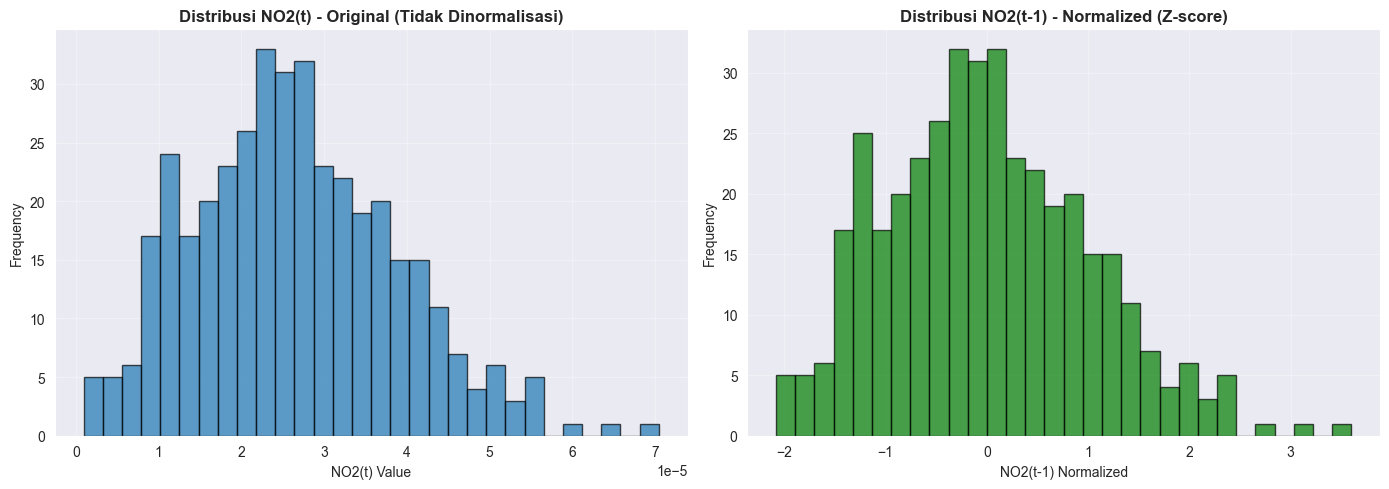

In [5]:
print("\n" + "="*70)
print("LANGKAH 4: NORMALISASI DATA")
print("="*70)

# StandardScaler (Z-score)
scaler = StandardScaler()

print(f"\nMetode Normalisasi: StandardScaler (Z-score)")
print(f"  - Formula: (x - mean) / std")
print(f"  - Range: [-∞, +∞]")
print(f"  - Mean hasil: 0, Std hasil: 1")

# Statistik SEBELUM
print(f"\nStatistik SEBELUM normalisasi:")
print(supervised_df.describe())

# Fit scaler hanya pada fitur input (3 kolom pertama)
X_features = supervised_df.iloc[:, :-1]  # Semua kolom kecuali NO2(t)
y_target = supervised_df.iloc[:, -1]     # Hanya kolom NO2(t)

# Fit scaler pada fitur input saja
scaler.fit(X_features)

# Transform fitur input
scaled_features = scaler.transform(X_features)

# Buat DataFrame dengan fitur yang sudah dinormalisasi
scaled_df = pd.DataFrame(scaled_features, columns=X_features.columns)

# CATATAN: Target NO2(t) TIDAK dinormalisasi untuk KNN Regression

# Statistik SESUDAH
print(f"\nNormalisasi selesai (hanya pada fitur input)")
print(f"\nStatistik SESUDAH normalisasi (fitur input):")
print(scaled_df.describe())

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(supervised_df["NO2(t)"], bins=30, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribusi NO2(t) - Original (Tidak Dinormalisasi)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("NO2(t) Value")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, alpha=0.3)

axes[1].hist(scaled_df["NO2(t-1)"], bins=30, edgecolor="black", alpha=0.7, color="green")
axes[1].set_title("Distribusi NO2(t-1) - Normalized (Z-score)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO2(t-1) Normalized")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## LANGKAH 5: Definisikan Batas Ambang (Threshold) dan Buat Labels

**Kategori: DATA PREPARATION**

**Tujuan**: Tentukan threshold untuk klasifikasi binary (Aman/Berbahaya)

**Proses**:
1. Hitung threshold menggunakan 75th percentile
2. Buat binary labels (0=AMAN, 1=BERBAHAYA)
3. Analisis distribusi kelas
4. Visualisasi class balance

**Catatan**: Labels ini akan digunakan untuk evaluasi setelah prediksi regression


LANGKAH 5: DEFINISIKAN THRESHOLD (BATAS AMBANG)

Threshold Definition:
  - Menggunakan: 75th percentile
  - Nilai threshold: 0.00003487 mol/m²

  - Label 0 (AMAN):      NO2 ≤ 0.00003487
  - Label 1 (BERBAHAYA): NO2 > 0.00003487

Distribusi Label (untuk evaluasi threshold):
  - Label 0 (AMAN):      294 samples (75.0%)
  - Label 1 (BERBAHAYA): 98 samples (25.0%)


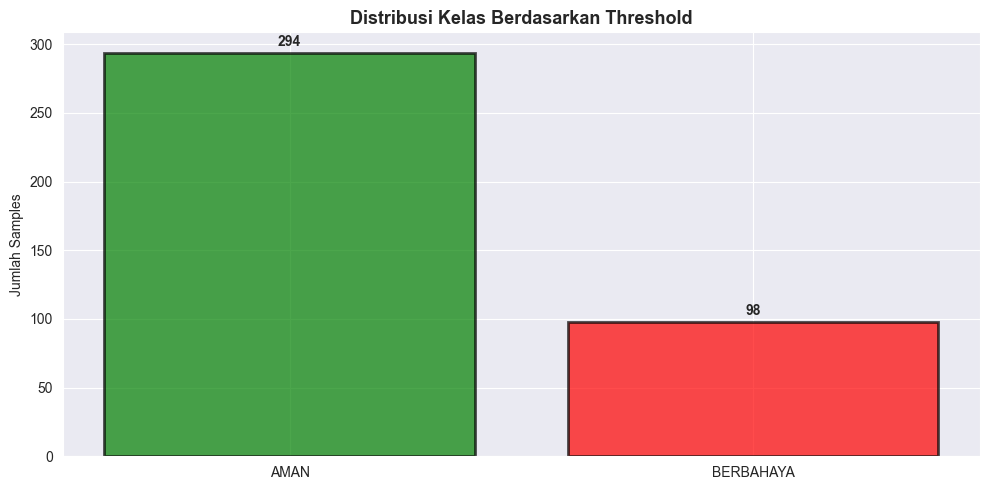


Threshold berhasil didefinisikan
CATATAN: Model akan memprediksi nilai NO2 (regression), lalu threshold diterapkan


In [6]:
print("\n" + "="*70)
print("LANGKAH 5: DEFINISIKAN THRESHOLD (BATAS AMBANG)")
print("="*70)

# Gunakan 75th percentile sebagai threshold
threshold = supervised_df["NO2(t)"].quantile(0.75)

print(f"\nThreshold Definition:")
print(f"  - Menggunakan: 75th percentile")
print(f"  - Nilai threshold: {threshold:.8f} mol/m²")
print(f"\n  - Label 0 (AMAN):      NO2 ≤ {threshold:.8f}")
print(f"  - Label 1 (BERBAHAYA): NO2 > {threshold:.8f}")

# Buat binary labels untuk evaluasi nanti (setelah regression)
binary_labels = (supervised_df["NO2(t)"] > threshold).astype(int)

# Statistik label
print(f"\nDistribusi Label (untuk evaluasi threshold):")
label_counts = binary_labels.value_counts().sort_index()
print(f"  - Label 0 (AMAN):      {label_counts[0]} samples ({label_counts[0]/len(binary_labels)*100:.1f}%)")
print(f"  - Label 1 (BERBAHAYA): {label_counts[1]} samples ({label_counts[1]/len(binary_labels)*100:.1f}%)")

# Visualisasi class distribution
fig, ax = plt.subplots(figsize=(10, 5))
labels_text = ['AMAN', 'BERBAHAYA']
colors_bar = ['green', 'red']
ax.bar(labels_text, label_counts.values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_title('Distribusi Kelas Berdasarkan Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('Jumlah Samples')
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nThreshold berhasil didefinisikan")
print(f"CATATAN: Model akan memprediksi nilai NO2 (regression), lalu threshold diterapkan")

---

# MODELLING

**Modelling** adalah tahap membangun, melatih, dan mengevaluasi model machine learning.

## Yang Dilakukan dalam Tahap Ini:

### 1. Model Training (Langkah 6)
- Memilih algoritma: **KNN Regression**
- **Eksperimen dengan nilai K** yang berbeda (2, 3, 5, 7, 9, 11)
- Training model untuk setiap K
- Evaluasi dengan metrik: **RMSE, MAE, R²**
- Memilih K terbaik (RMSE terkecil)

### 2. Model Evaluation (Langkah 7)
- Training model final dengan K terbaik
- **Prediksi nilai NO₂** pada test set
- Evaluasi performa regression (RMSE, MAE, R²)
- **Terapkan threshold** untuk klasifikasi
- Evaluasi performa classification (Accuracy, Precision, Recall, F1)
- Visualisasi dengan Confusion Matrix

### 3. Prediction Analysis (Langkah 8)
- Analisis error distribution
- Residual analysis
- Visualisasi performa model

### 4. Deployment (Langkah 9)
- **Prediksi NO₂ satu hari ke depan**
- Terapkan threshold untuk status (AMAN/BERBAHAYA)
- Interpretasi hasil prediksi

**Output**: Model KNN Regression terlatih dan hasil prediksi NO₂

---


## LANGKAH 6: KNN Regression Modeling

**Kategori: MODELLING**

**Tujuan**: Training model KNN Regression untuk memprediksi nilai NO₂ kontinyu dengan berbagai nilai K

**Proses**:
1. Prepare data (X features, y target)
2. Split data: 80% training, 20% testing (shuffle=False)
3. **Eksperimen dengan berbagai nilai K** (2, 3, 5, 7, 9, 11)
4. Training model untuk setiap K
5. Evaluasi dengan metrik regression (RMSE, MAE, R²)
6. Pilih K terbaik berdasarkan RMSE terkecil


LANGKAH 6: KNN REGRESSION MODELING

Data Preparation:
  - Features shape: (392, 3) (3 lagged features - normalized)
  - Target shape: (392,) (original NO2 values)
  - Target range: [0.00000093, 0.00007045] mol/m²

Data Split:
  - Training set: 313 samples (79.8%)
  - Test set: 79 samples (20.2%)

----------------------------------------------------------------------
EKSPERIMEN: Variasi Nilai K untuk KNN Regression
----------------------------------------------------------------------
k= 2 | RMSE=0.00000926 | MAE=0.00000623 | R²=0.3565
k= 3 | RMSE=0.00000833 | MAE=0.00000592 | R²=0.4803
k= 5 | RMSE=0.00000778 | MAE=0.00000558 | R²=0.5461
k= 7 | RMSE=0.00000751 | MAE=0.00000554 | R²=0.5767
k= 9 | RMSE=0.00000725 | MAE=0.00000532 | R²=0.6055
k=11 | RMSE=0.00000713 | MAE=0.00000523 | R²=0.6184

Best K: 11 (RMSE=0.00000713)


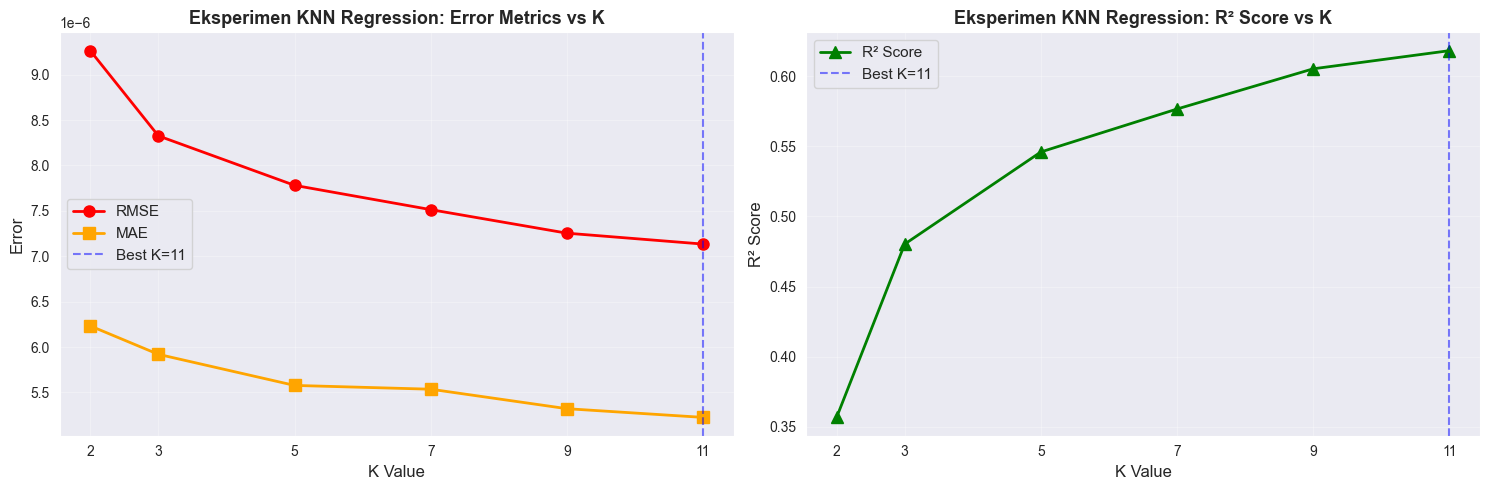

In [7]:
print("\n" + "="*70)
print("LANGKAH 6: KNN REGRESSION MODELING")
print("="*70)

# Prepare data
X = scaled_df.values  # Semua 3 kolom sebagai features (normalized)
y = supervised_df["NO2(t)"].values  # Target asli (tidak dinormalisasi)

print(f"\nData Preparation:")
print(f"  - Features shape: {X.shape} (3 lagged features - normalized)")
print(f"  - Target shape: {y.shape} (original NO2 values)")
print(f"  - Target range: [{y.min():.8f}, {y.max():.8f}] mol/m²")

# Train-test split (80-20, shuffle=False untuk time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"\nData Split:")
print(f"  - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Eksperimen berbagai K
k_values = [2, 3, 5, 7, 9, 11]
print(f"\n" + "-"*70)
print(f"EKSPERIMEN: Variasi Nilai K untuk KNN Regression")
print("-"*70)

results_k = []
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrik regression
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_k.append({
        'k': k,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })
    
    print(f"k={k:2d} | RMSE={rmse:.8f} | MAE={mae:.8f} | R²={r2:.4f}")

results_k_df = pd.DataFrame(results_k)
best_k_idx = results_k_df['rmse'].idxmin()  # Cari K dengan RMSE terkecil
best_k = results_k_df.loc[best_k_idx, 'k']
best_rmse = results_k_df.loc[best_k_idx, 'rmse']

print(f"\nBest K: {int(best_k)} (RMSE={best_rmse:.8f})")

# Visualisasi performa vs K
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: RMSE dan MAE
axes[0].plot(results_k_df['k'], results_k_df['rmse'], marker='o', linewidth=2, markersize=8, label='RMSE', color='red')
axes[0].plot(results_k_df['k'], results_k_df['mae'], marker='s', linewidth=2, markersize=8, label='MAE', color='orange')
axes[0].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[0].set_xlabel('K Value', fontsize=12)
axes[0].set_ylabel('Error', fontsize=12)
axes[0].set_title('Eksperimen KNN Regression: Error Metrics vs K', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Plot 2: R² Score
axes[1].plot(results_k_df['k'], results_k_df['r2'], marker='^', linewidth=2, markersize=8, label='R² Score', color='green')
axes[1].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[1].set_xlabel('K Value', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Eksperimen KNN Regression: R² Score vs K', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

plt.tight_layout()
plt.show()

---

## LANGKAH 7: Evaluasi Regression & Threshold Application

**Kategori: MODELLING (Evaluation)**

**Tujuan**: Evaluasi hasil prediksi regression dan terapkan threshold untuk klasifikasi

**Proses**:
1. **Training final model** dengan K terbaik
2. **Prediksi nilai NO₂** pada test set (regression)
3. **Evaluasi Regression**: RMSE, MAE, R²
4. **Terapkan threshold** pada prediksi untuk klasifikasi
5. **Evaluasi Classification**: Accuracy, Precision, Recall, F1
6. **Visualisasi**: Actual vs Predicted, Residual Plot, Confusion Matrix


LANGKAH 7: EVALUASI REGRESSION & THRESHOLD APPLICATION

[A] REGRESSION METRICS (K=11):
  - MSE:  0.0000000001
  - RMSE: 0.0000071337
  - MAE:  0.0000052251
  - R²:   0.6184

[B] CLASSIFICATION METRICS (Setelah Threshold):
  - Threshold: 0.00003487 mol/m²
  - Accuracy:  0.8734
  - Precision: 0.6429
  - Recall:    0.6429
  - F1-Score:  0.6429

Confusion Matrix:
  - True Negatives (AMAN diprediksi AMAN):         60
  - False Positives (AMAN diprediksi BERBAHAYA):  5
  - False Negatives (BERBAHAYA diprediksi AMAN):  5
  - True Positives (BERBAHAYA diprediksi BERBAHAYA): 9


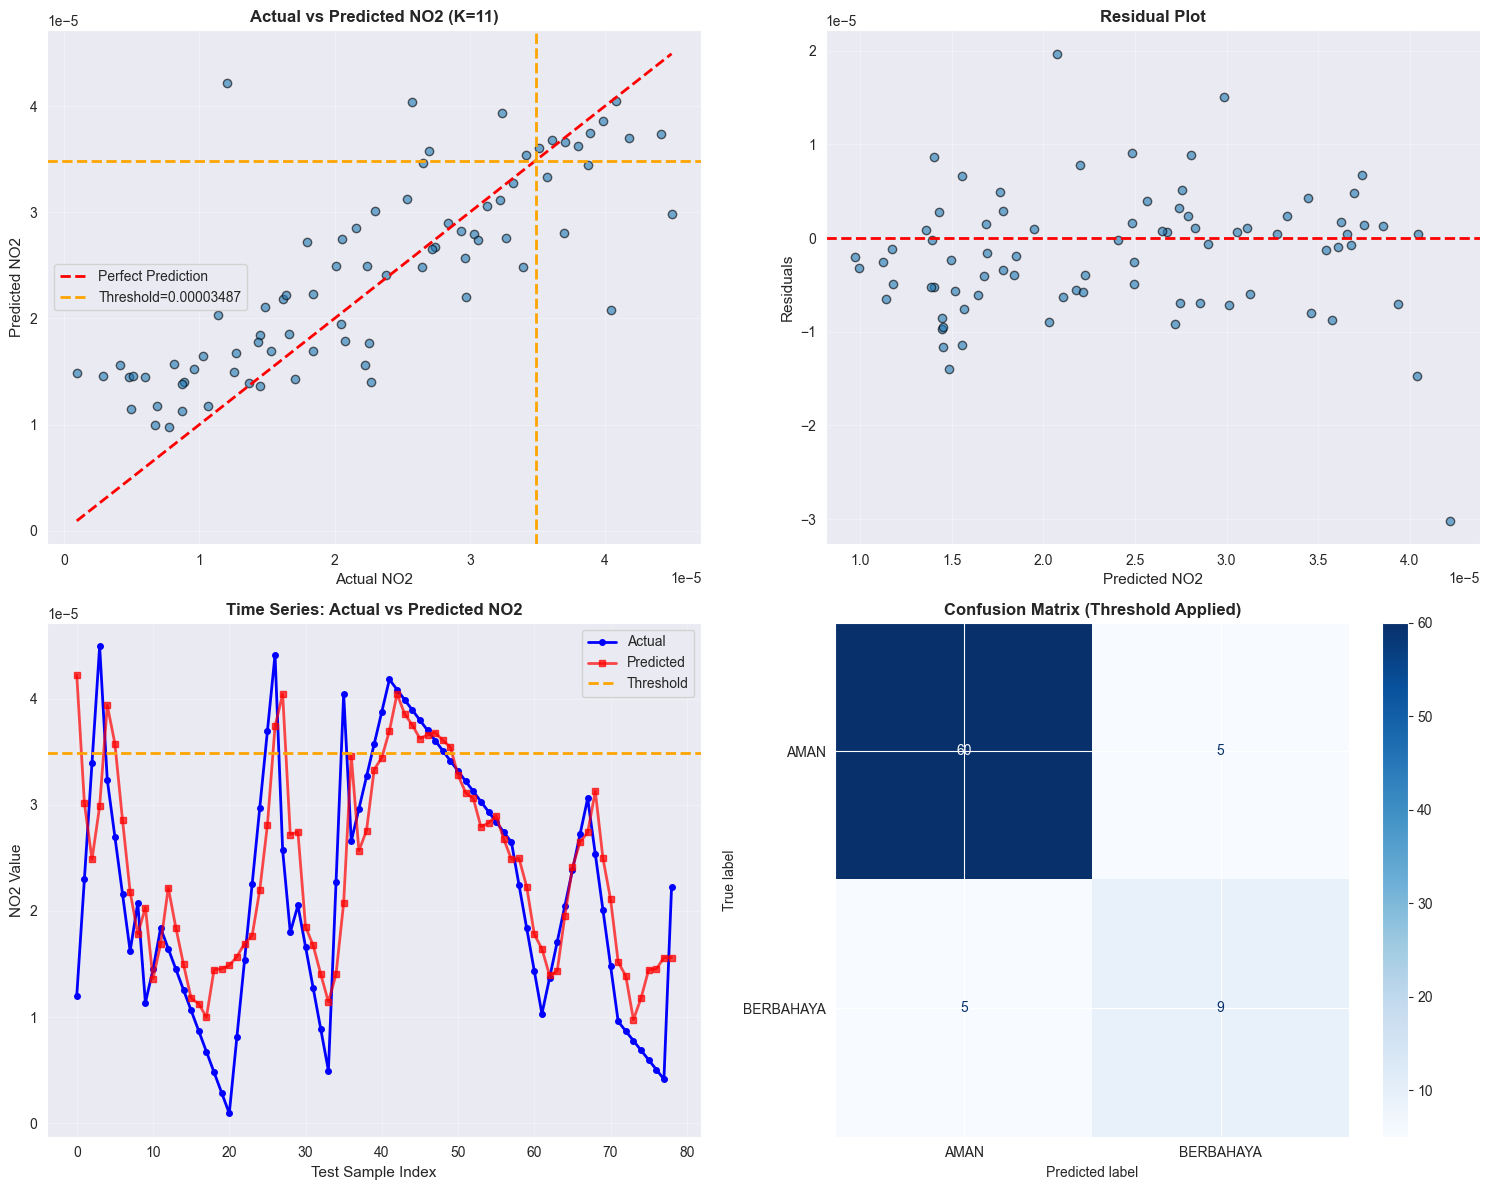


Classification Report (Setelah Threshold):
              precision    recall  f1-score   support

        AMAN       0.92      0.92      0.92        65
   BERBAHAYA       0.64      0.64      0.64        14

    accuracy                           0.87        79
   macro avg       0.78      0.78      0.78        79
weighted avg       0.87      0.87      0.87        79



In [8]:
print("\n" + "="*70)
print("LANGKAH 7: EVALUASI REGRESSION & THRESHOLD APPLICATION")
print("="*70)

# Train final model dengan best K
best_k = int(best_k)
final_model = KNeighborsRegressor(n_neighbors=best_k, metric='euclidean')
final_model.fit(X_train, y_train)

# Prediksi nilai NO2 (continuous)
y_pred_regression = final_model.predict(X_test)

# Hitung metrics regression
mse = mean_squared_error(y_test, y_pred_regression)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_regression)
r2 = r2_score(y_test, y_pred_regression)

print(f"\n[A] REGRESSION METRICS (K={best_k}):")
print(f"  - MSE:  {mse:.10f}")
print(f"  - RMSE: {rmse:.10f}")
print(f"  - MAE:  {mae:.10f}")
print(f"  - R²:   {r2:.4f}")

# Terapkan threshold pada prediksi
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred_regression > threshold).astype(int)

# Hitung metrics classification setelah threshold
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)

print(f"\n[B] CLASSIFICATION METRICS (Setelah Threshold):")
print(f"  - Threshold: {threshold:.8f} mol/m²")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  - True Negatives (AMAN diprediksi AMAN):         {tn}")
print(f"  - False Positives (AMAN diprediksi BERBAHAYA):  {fp}")
print(f"  - False Negatives (BERBAHAYA diprediksi AMAN):  {fn}")
print(f"  - True Positives (BERBAHAYA diprediksi BERBAHAYA): {tp}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted (Regression)
axes[0, 0].scatter(y_test, y_pred_regression, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold={threshold:.8f}')
axes[0, 0].axvline(x=threshold, color='orange', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Actual NO2', fontsize=11)
axes[0, 0].set_ylabel('Predicted NO2', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted NO2 (K={best_k})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residual Plot
residuals = y_test - y_pred_regression
axes[0, 1].scatter(y_pred_regression, residuals, alpha=0.6, edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted NO2', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Time Series Comparison
test_indices = range(len(y_test))
axes[1, 0].plot(test_indices, y_test, label='Actual', color='blue', linewidth=2, marker='o', markersize=4)
axes[1, 0].plot(test_indices, y_pred_regression, label='Predicted', color='red', linewidth=2, marker='s', markersize=4, alpha=0.7)
axes[1, 0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold')
axes[1, 0].set_xlabel('Test Sample Index', fontsize=11)
axes[1, 0].set_ylabel('NO2 Value', fontsize=11)
axes[1, 0].set_title('Time Series: Actual vs Predicted NO2', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AMAN', 'BERBAHAYA'])
disp.plot(ax=axes[1, 1], cmap='Blues', values_format='d')
axes[1, 1].set_title(f'Confusion Matrix (Threshold Applied)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Classification Report
print(f"\nClassification Report (Setelah Threshold):")
print(classification_report(y_test_binary, y_pred_binary, target_names=['AMAN', 'BERBAHAYA']))

---

## LANGKAH 8: Visualization - Prediction Analysis

**Kategori: MODELLING (Evaluation & Analysis)**

**Tujuan**: Analisis mendalam terhadap hasil prediksi model

**Visualisasi**:
1. **Error Distribution**: Histogram error absolut
2. **Prediction vs Actual dengan Kategori**: Scatter plot dengan warna
3. **Binary Classification Result**: Bar chart perbandingan
4. **Percentage Error**: Analisis error relatif


LANGKAH 8: VISUALIZATION - PREDICTION ANALYSIS

Error Analysis:
  - Mean Absolute Error: 0.00000523
  - Median Absolute Error: 0.00000432
  - Max Error: 0.00003018
  - Min Error: 0.00000024


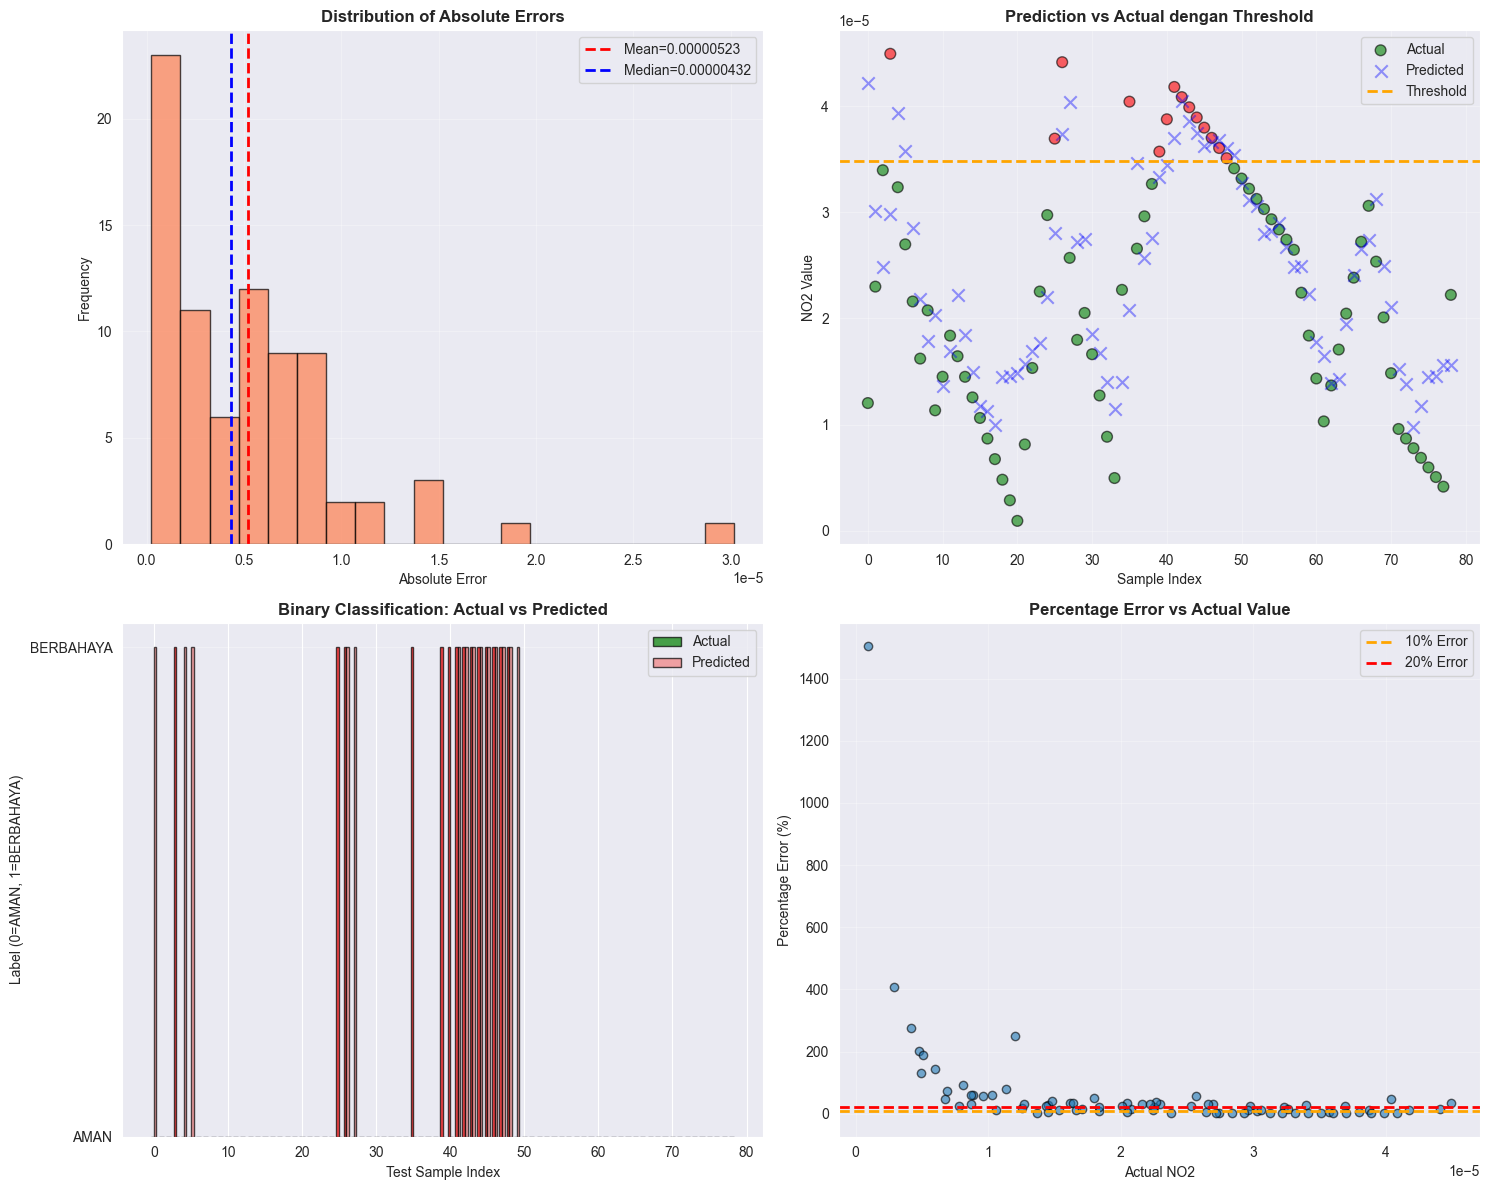


Visualisasi selesai


In [9]:
print("\n" + "="*70)
print("LANGKAH 8: VISUALIZATION - PREDICTION ANALYSIS")
print("="*70)

# Analisis error distribution
errors = np.abs(y_test - y_pred_regression)
mean_error = np.mean(errors)
median_error = np.median(errors)

print(f"\nError Analysis:")
print(f"  - Mean Absolute Error: {mean_error:.8f}")
print(f"  - Median Absolute Error: {median_error:.8f}")
print(f"  - Max Error: {errors.max():.8f}")
print(f"  - Min Error: {errors.min():.8f}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Error Distribution
axes[0, 0].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].axvline(x=mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_error:.8f}')
axes[0, 0].axvline(x=median_error, color='blue', linestyle='--', linewidth=2, label=f'Median={median_error:.8f}')
axes[0, 0].set_xlabel('Absolute Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction vs Actual dengan kategori
colors_scatter = ['green' if val <= threshold else 'red' for val in y_test]
axes[0, 1].scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual', c=colors_scatter, edgecolors='k', s=60)
axes[0, 1].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.4, label='Predicted', marker='x', s=80, c='blue')
axes[0, 1].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('NO2 Value')
axes[0, 1].set_title('Prediction vs Actual dengan Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Binary Classification Result
x_pos = np.arange(len(y_test_binary))
width = 0.35
colors_actual = ['green' if x == 0 else 'red' for x in y_test_binary]
colors_pred = ['lightgreen' if x == 0 else 'lightcoral' for x in y_pred_binary]

axes[1, 0].bar(x_pos - width/2, y_test_binary, width, label='Actual', color=colors_actual, alpha=0.7, edgecolor='black')
axes[1, 0].bar(x_pos + width/2, y_pred_binary, width, label='Predicted', color=colors_pred, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Test Sample Index')
axes[1, 0].set_ylabel('Label (0=AMAN, 1=BERBAHAYA)')
axes[1, 0].set_title('Binary Classification: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['AMAN', 'BERBAHAYA'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Percentage Error
percentage_error = (errors / y_test) * 100
axes[1, 1].scatter(y_test, percentage_error, alpha=0.6, edgecolors='k')
axes[1, 1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='10% Error')
axes[1, 1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='20% Error')
axes[1, 1].set_xlabel('Actual NO2')
axes[1, 1].set_ylabel('Percentage Error (%)')
axes[1, 1].set_title('Percentage Error vs Actual Value', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualisasi selesai")

---

## LANGKAH 9: Prediksi Nilai NO2 Satu Hari Ke Depan

**Kategori: MODELLING (Deployment/Application)**

**Tujuan**: Gunakan model untuk prediksi status NO₂ satu hari ke depan

**Proses**:
1. Ambil 3 hari terakhir dari data (NO2(t-3), NO2(t-2), NO2(t-1))
2. Normalisasi dengan scaler yang sudah di-fit
3. **Prediksi nilai NO₂** menggunakan final model
4. **Terapkan threshold** untuk klasifikasi status
5. Analisis: persentase perbedaan dari threshold
6. **Visualisasi prediksi** dengan bar chart


LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN

Data 3 hari terakhir (Original):
  - NO2(t-3): 0.00000596 mol/m²
  - NO2(t-2): 0.00000505 mol/m²
  - NO2(t-1): 0.00000415 mol/m²

Data 3 hari terakhir (Normalized):
  - NO2(t-3): -1.6819
  - NO2(t-2): -1.7510
  - NO2(t-1): -1.8191

HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)

[A] PREDIKSI NILAI NO2 (Regression):
  - Predicted NO2: 0.00001559 mol/m²

[B] THRESHOLD APPLICATION:
  - Threshold: 0.00003487 mol/m²
  - Status: AMAN
  - Difference: -0.00001928 mol/m²
  - Percentage: -55.29% dari threshold

✓ AMAN: NO2 diprediksi 55.3% di bawah threshold
   → Kualitas udara dalam batas aman


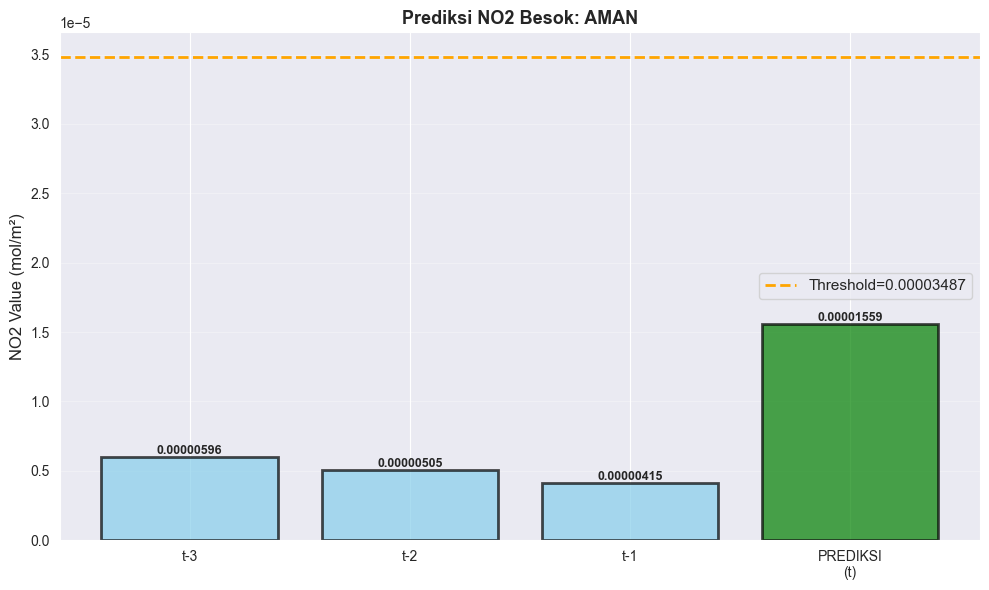

In [10]:
print("\n" + "="*70)
print("LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN")
print("="*70)

# Ambil 3 hari terakhir dari supervised_df (data asli)
last_3_days_original = supervised_df[["NO2(t-3)", "NO2(t-2)", "NO2(t-1)"]].iloc[-1].values

print(f"\nData 3 hari terakhir (Original):")
print(f"  - NO2(t-3): {last_3_days_original[0]:.8f} mol/m²")
print(f"  - NO2(t-2): {last_3_days_original[1]:.8f} mol/m²")
print(f"  - NO2(t-1): {last_3_days_original[2]:.8f} mol/m²")

# Normalisasi
last_3_days_scaled = scaler.transform([last_3_days_original])[0]

print(f"\nData 3 hari terakhir (Normalized):")
print(f"  - NO2(t-3): {last_3_days_scaled[0]:.4f}")
print(f"  - NO2(t-2): {last_3_days_scaled[1]:.4f}")
print(f"  - NO2(t-1): {last_3_days_scaled[2]:.4f}")

# Reshape untuk input model
X_tomorrow = last_3_days_scaled.reshape(1, -1)

# Prediksi nilai NO2 (regression)
pred_no2_value = final_model.predict(X_tomorrow)[0]

# Terapkan threshold
pred_status = 'BERBAHAYA' if pred_no2_value > threshold else 'AMAN'
difference_from_threshold = pred_no2_value - threshold
percentage_diff = (difference_from_threshold / threshold) * 100

print("\n" + "="*70)
print("HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)")
print("="*70)
print(f"\n[A] PREDIKSI NILAI NO2 (Regression):")
print(f"  - Predicted NO2: {pred_no2_value:.8f} mol/m²")

print(f"\n[B] THRESHOLD APPLICATION:")
print(f"  - Threshold: {threshold:.8f} mol/m²")
print(f"  - Status: {pred_status}")
print(f"  - Difference: {difference_from_threshold:.8f} mol/m²")
print(f"  - Percentage: {percentage_diff:+.2f}% dari threshold")

if pred_status == 'BERBAHAYA':
    if percentage_diff > 20:
        print(f"\n PERINGATAN TINGGI: NO2 diprediksi {percentage_diff:.1f}% DI ATAS threshold!")
        print(f"   → Prediksi SANGAT BERBAHAYA, ambil tindakan pencegahan!")
    elif percentage_diff > 10:
        print(f"\n PERINGATAN SEDANG: NO2 diprediksi {percentage_diff:.1f}% di atas threshold")
        print(f"   → Status BERBAHAYA, waspadai kualitas udara!")
    else:
        print(f"\n PERINGATAN: NO2 diprediksi {percentage_diff:.1f}% di atas threshold")
        print(f"   → Status BERBAHAYA, perlu monitoring!")
else:
    if abs(percentage_diff) < 5:
        print(f"\n✓ HATI-HATI: NO2 diprediksi hanya {abs(percentage_diff):.1f}% DI BAWAH threshold")
        print(f"   → Status masih AMAN, tapi mendekati batas ambang!")
    else:
        print(f"\n✓ AMAN: NO2 diprediksi {abs(percentage_diff):.1f}% di bawah threshold")
        print(f"   → Kualitas udara dalam batas aman")

# Visualisasi prediksi
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 3 hari terakhir + prediksi
days = ['t-3', 't-2', 't-1', 'PREDIKSI\n(t)']
values = list(last_3_days_original) + [pred_no2_value]
colors_bar = ['skyblue', 'skyblue', 'skyblue', 'red' if pred_status == 'BERBAHAYA' else 'green']

bars = ax.bar(days, values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold={threshold:.8f}')
ax.set_ylabel('NO2 Value (mol/m²)', fontsize=12)
ax.set_title(f'Prediksi NO2 Besok: {pred_status}', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Tambah label nilai di atas bar
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.8f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

---

## RINGKASAN HASIL

In [16]:

print("RINGKASAN PIPELINE NO2 PREDICTION (KNN REGRESSION)")


print(f"""
1. DATA COLLECTION (Sentinel-5P OpenEO)
   - Lokasi: Bangkalan, Madura
   - Periode: {df['date'].min().date()} - {df['date'].max().date()}
   - Total samples: {len(df)}
   - Output: timeseries.csv

2. PREPROCESSING (Interpolasi)
   - Missing values sebelum: {missing_before}
   - Missing values sesudah: {missing_after}
   - Metode: Linear Interpolation

3. SUPERVISED TRANSFORMATION
   - Lagged features: {n_lags} lag
   - Input features: [NO2(t-3), NO2(t-2), NO2(t-1)]
   - Target: NO2(t)
   - Total samples: {len(supervised_df)}

4. NORMALISASI
   - Metode: StandardScaler (Z-score)
   - Training set: {len(X_train)} samples
   - Test set: {len(X_test)} samples

5. THRESHOLD DEFINITION
   - Threshold: {threshold:.8f} mol/m²
   - Percentile: 75th

6. KNN REGRESSION MODEL (K={best_k})
   - RMSE: {rmse:.8f}
   - MAE: {mae:.8f}
   - R²: {r2:.4f}

7. THRESHOLD APPLICATION (Classification Metrics)
   - Accuracy: {accuracy:.4f}
   - Precision: {precision:.4f}
   - Recall: {recall:.4f}
   - F1-Score: {f1:.4f}

8. PREDIKSI HARI BESOK
   - Predicted NO2: {pred_no2_value:.8f} mol/m²
   - Threshold: {threshold:.8f} mol/m²
   - Status: {pred_status}
   - Difference: {difference_from_threshold:+.8f} mol/m²
   - Percentage: {percentage_diff:+.2f}% dari threshold
""")



RINGKASAN PIPELINE NO2 PREDICTION (KNN REGRESSION)

1. DATA COLLECTION (Sentinel-5P OpenEO)
   - Lokasi: Bangkalan, Madura
   - Periode: 2020-05-31 - 2021-06-29
   - Total samples: 395
   - Output: timeseries.csv

2. PREPROCESSING (Interpolasi)
   - Missing values sebelum: 261
   - Missing values sesudah: 0
   - Metode: Linear Interpolation

3. SUPERVISED TRANSFORMATION
   - Lagged features: 3 lag
   - Input features: [NO2(t-3), NO2(t-2), NO2(t-1)]
   - Target: NO2(t)
   - Total samples: 392

4. NORMALISASI
   - Metode: StandardScaler (Z-score)
   - Training set: 313 samples
   - Test set: 79 samples

5. THRESHOLD DEFINITION
   - Threshold: 0.00003487 mol/m²
   - Percentile: 75th

6. KNN REGRESSION MODEL (K=11)
   - RMSE: 0.00000713
   - MAE: 0.00000523
   - R²: 0.6184

7. THRESHOLD APPLICATION (Classification Metrics)
   - Accuracy: 0.8734
   - Precision: 0.6429
   - Recall: 0.6429
   - F1-Score: 0.6429

8. PREDIKSI HARI BESOK
   - Predicted NO2: 0.00001559 mol/m²
   - Threshold: 0.00